In [1]:
# Import packages
import rasterio
import rasterio.plot
import pyproj
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import pylab
import mahotas as mh
import cv2

In [3]:
from Functions import create_dirs, check_sky, mask_seg, count_animals,smooth_animals, get_bboxes,write_file, get_centers_through_borders

In [4]:
# Create the data directories
create_dirs()

Creation of the directory ../Data/images/2019-10 failed
Creation of the directory ../Data/labels/2019-10 failed
Creation of the directory ../Data/semantic/2019-10 failed


In [7]:
input_location = "../Data/images/2019-10/"
input_location_s = "../Data/semantic/2019-10/"
output_location = "../Data/labels/2019-10/"

bad_image_list1 = []

sigma = 2
minimum_animal_size = 10

#clean_distance =  20 old

['IMG1000_175,250_.png', 'IMG1001_200,250_.png', 'IMG1002_225,250_.png', 'IMG1003_250,250_.png', 'IMG1004_275,250_.png', 'IMG1005_300,250_.png', 'IMG1006_325,250_.png', 'IMG1007_350,250_.png', 'IMG1008_375,250_.png', 'IMG1009_400,250_.png', 'IMG100_-800,-675_.png', 'IMG1010_425,250_.png', 'IMG1011_450,250_.png', 'IMG1012_475,250_.png', 'IMG1013_500,250_.png', 'IMG1014_525,250_.png', 'IMG1015_550,250_.png', 'IMG1016_575,250_.png', 'IMG1017_600,250_.png', 'IMG1018_625,250_.png', 'IMG1019_650,250_.png', 'IMG101_-800,-700_.png', 'IMG1020_675,250_.png', 'IMG1021_700,250_.png', 'IMG1022_725,250_.png', 'IMG1023_750,250_.png', 'IMG1024_775,250_.png', 'IMG1025_800,250_.png', 'IMG1026_825,250_.png', 'IMG1027_850,250_.png', 'IMG1028_875,250_.png', 'IMG1029_900,250_.png', 'IMG102_-800,-725_.png', 'IMG1030_925,250_.png', 'IMG1031_950,250_.png', 'IMG1032_975,250_.png', 'IMG1033_1000,250_.png', 'IMG1034_1025,250_.png', 'IMG1035_1050,250_.png', 'IMG1036_1075,250_.png', 'IMG1037_1100,250_.png', 'IMG103

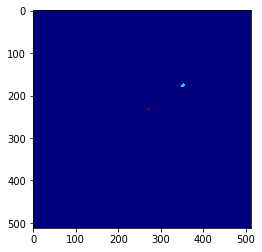

[(0.6397352430555555, 0.3946397569444444), (0.6875, 0.344482421875), (0.8251953125, 0.439453125)]
IMG1001_200,250_.png
This image contains 3 animals


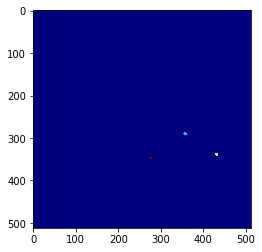

[(0.7022429435483871, 0.6324029737903226), (0.6971768465909091, 0.5662286931818182), (0.8408203125, 0.66015625)]
IMG1002_225,250_.png
This image contains 3 animals


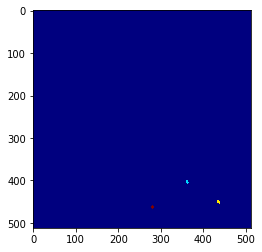

[(0.7104344223484849, 0.8588423295454546), (0.70634765625, 0.787890625), (0.8500390625, 0.8785546875)]
IMG1003_250,250_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG1004_275,250_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG1005_300,250_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG1006_325,250_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG1007_350,250_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG1008_375,250_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG1009_400,250_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG100_-800,-675_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG1010_425,250_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG1011_450,250_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG101

This image contains 0 animals
Zero animals in this picture, passing
IMG147_125,-1075_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG148_150,-1075_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG149_175,-1075_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG14_-175,325_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG150_200,-1075_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG151_225,-1075_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG152_250,-1075_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG153_275,-1075_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG154_300,-1075_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG155_325,-1075_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG156_350,-1075_.png
This image c

This image contains 0 animals
Zero animals in this picture, passing
IMG232_550,-825_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG233_525,-825_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG234_500,-825_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG235_475,-825_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG236_450,-825_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG237_425,-825_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG238_400,-825_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG239_375,-825_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG23_-175,550_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG240_350,-825_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG241_325,-825_.png
This image contains 0 

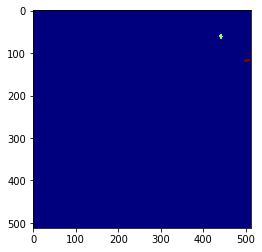

[(0.9232295866935484, 0.17697832661290322), (0.8621744791666667, 0.12024739583333334)]
IMG300_-1150,-650_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG301_-1175,-625_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG302_-1200,-600_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG303_-1225,-575_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG304_-1250,-550_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG305_-1275,-525_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG306_-1300,-500_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG307_-1325,-475_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG308_-1350,-450_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG309_-1375,-425_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG

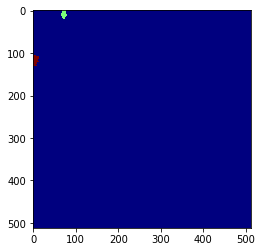

[(0.07756696428571429, 0.1272750686813187), (0.14069010416666666, 0.020963541666666665)]
IMG379_-475,-525_.png
This image contains 4 animals


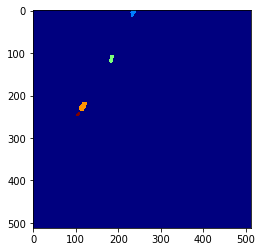

[(0.30823455459770116, 0.29860924030172414), (0.4561631944444444, 0.016520182291666668), (0.3591715494791667, 0.2227783203125), (0.22867313508064516, 0.4403036794354839)]
IMG37_-175,900_.png
Warning, picture contains sky, passing
IMG380_-450,-550_.png
This image contains 5 animals


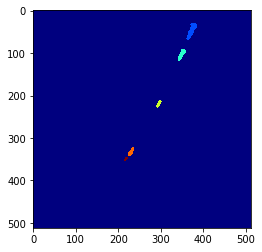

[(0.6158666816546763, 0.3227222909172662), (0.7255037006578947, 0.0949732730263158), (0.6801101912313433, 0.20386835354477612), (0.5763862423780488, 0.4282345655487805), (0.44931449142156865, 0.6488779105392157)]
IMG381_-425,-575_.png
This image contains 5 animals


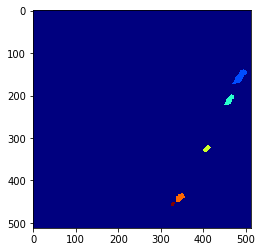

[(0.8255086124146758, 0.553944245947099), (0.9475840692934783, 0.30668308423913043), (0.8996803977272727, 0.412109375), (0.7959428267045454, 0.6352982954545454), (0.6724795386904762, 0.8580574156746031)]
IMG382_-400,-600_.png
This image contains 1 animals


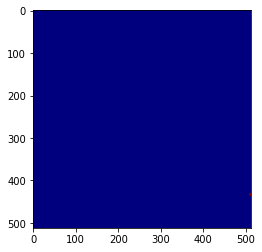

[(0.9932454427083334, 0.84423828125)]
IMG383_-375,-625_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG384_-350,-650_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG385_-325,-675_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG386_-300,-700_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG387_-275,-725_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG388_-250,-750_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG389_-225,-775_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG38_-200,875_.png
Warning, picture contains sky, passing
IMG390_-200,-800_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG391_-175,-825_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG392_-150,-850_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG

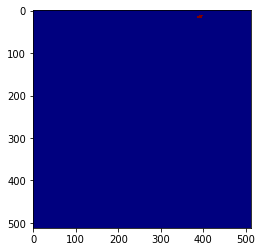

[(0.7660345262096774, 0.028068296370967742)]
IMG400_50,-1050_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG401_75,-1075_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG402_100,-1075_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG403_125,-1075_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG404_150,-1075_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG405_175,-1075_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG406_200,-1075_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG407_225,-1075_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG408_250,-1075_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG409_275,-1075_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG40_-250,825_.png
Warning, picture contains sky, passin

This image contains 0 animals
Zero animals in this picture, passing
IMG488_550,-225_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG489_525,-200_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG48_-450,625_.png
Warning, picture contains sky, passing
IMG490_500,-175_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG491_475,-150_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG492_450,-125_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG493_425,-100_.png
This image contains 1 animals


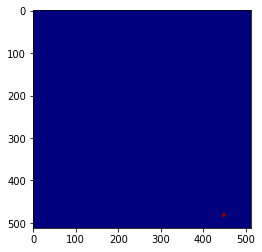

[(0.8754377693965517, 0.9398908943965517)]
IMG494_400,-75_.png
This image contains 2 animals


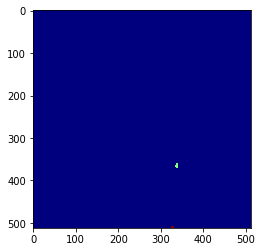

[(0.6527010289634146, 0.7953506097560976), (0.6585061961206896, 0.7134630926724138)]
IMG495_375,-50_.png
This image contains 3 animals


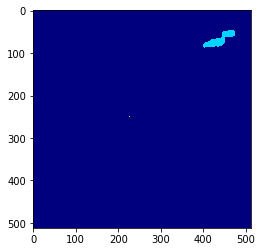

[(0.831541757133995, 0.16397526364764267), (0.8559930098684211, 0.1337171052631579), (0.4417317708333333, 0.48828125)]
IMG496_350,-25_.png
This image contains 4 animals


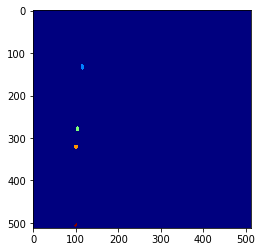

[(0.20619419642857142, 0.5779506138392857), (0.22489289314516128, 0.2592930947580645), (0.20431082589285715, 0.5448521205357143), (0.1962890625, 0.6261067708333333)]
IMG497_325,0_.png
This image contains 2 animals


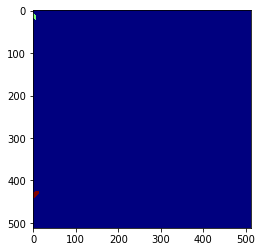

[(0.011372227822580645, 0.4625441028225806), (0.0078125, 0.030812230603448277)]
IMG498_300,25_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG499_275,50_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG49_-475,600_.png
Warning, picture contains sky, passing
IMG4_-75,75_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG500_250,75_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG501_225,75_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG502_200,75_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG503_175,75_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG504_150,75_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG505_125,75_.png
This image contains 1 animals


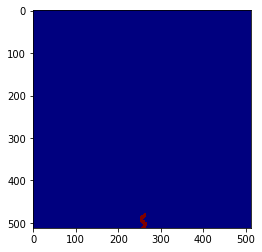

[(0.5061451981707317, 0.9629978086890244)]
IMG506_100,75_.png
This image contains 4 animals


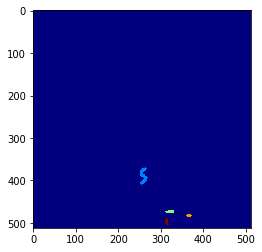

[(0.5797438063063063, 0.8593310106981982), (0.5048636642156863, 0.7591337316176471), (0.6268717447916666, 0.9232177734375), (0.7145406788793104, 0.9417766702586207)]
IMG507_75,75_.png
This image contains 12 animals


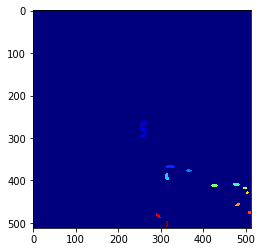

[(0.7036711758948546, 0.7587978013143176), (0.5049923335280374, 0.5471031688084113), (0.6283637152777778, 0.7170789930555556), (0.71484375, 0.736328125), (0.6138671875, 0.7629557291666667), (0.9307725694444444, 0.7998046875), (0.8315011160714286, 0.8039341517857143), (0.971085258152174, 0.8155995244565217), (0.9819592927631579, 0.8366056743421053), (0.9393136160714286, 0.8916713169642857), (0.99127197265625, 0.9285888671875), (0.5738525390625, 0.94256591796875)]
IMG508_50,75_.png
This image contains 12 animals


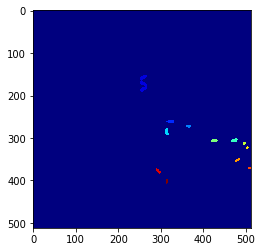

[(0.7057512229848131, 0.5530218676985982), (0.5049396996359223, 0.33532122269417475), (0.6279296875, 0.5107421875), (0.7139369419642857, 0.5311802455357143), (0.6130668826219512, 0.5578553734756098), (0.9232979910714286, 0.5970703125), (0.8310546875, 0.5985753676470589), (0.9701915922619048, 0.6099795386904762), (0.9820620888157895, 0.6302939967105263), (0.9384114583333333, 0.6863932291666667), (0.99127197265625, 0.72314453125), (0.57403564453125, 0.737548828125)]
IMG509_25,75_.png
This image contains 12 animals


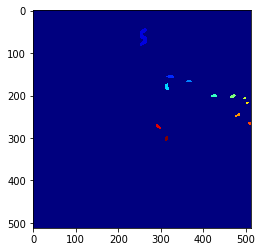

[(0.7017740885416667, 0.3455450148809524), (0.5048638501213593, 0.12282880764563107), (0.6283839026162791, 0.3044376816860465), (0.7147739955357143, 0.32547433035714285), (0.6133563701923077, 0.3518379407051282), (0.8305220170454546, 0.3929036458333333), (0.91619873046875, 0.39447021484375), (0.9697265625, 0.4048828125), (0.982421875, 0.4250217013888889), (0.9380724676724138, 0.4810412176724138), (0.99127197265625, 0.51806640625), (0.5738722278225806, 0.5326675907258065)]
IMG50_-500,575_.png
Warning, picture contains sky, passing
IMG510_0,75_.png
This image contains 11 animals


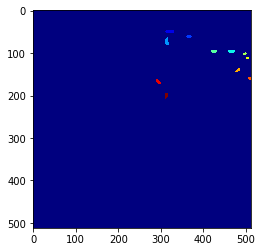

[(0.7615023688046647, 0.21126491891399418), (0.6268717447916666, 0.09814453125), (0.7144059806034483, 0.12058863146551724), (0.6140407986111112, 0.14381510416666668), (0.9101019965277778, 0.18880208333333334), (0.8306082589285714, 0.18758370535714286), (0.9702360733695652, 0.19892153532608695), (0.982421875, 0.2197265625), (0.9393136160714286, 0.27511160714285715), (0.9906939338235294, 0.31267233455882354), (0.5731847426470589, 0.32634420955882354)]
IMG511_-25,75_.png
This image contains 5 animals


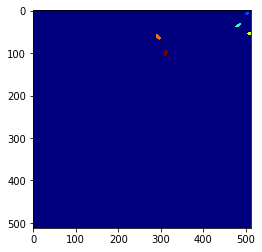

[(0.7928994902482269, 0.1072764295212766), (0.982421875, 0.0146484375), (0.9399256552419355, 0.06895791330645161), (0.9877717391304348, 0.10627547554347826), (0.5734719669117647, 0.12218520220588236)]
IMG512_-50,75_.png
This image contains 1 animals


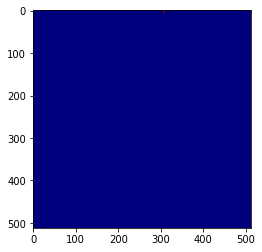

[(0.6007080078125, 0.00665283203125)]
IMG513_-75,75_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG514_-100,75_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG515_-125,75_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG516_-150,75_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG517_-175,75_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG518_-200,75_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG519_-225,75_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG51_-525,550_.png
Warning, picture contains sky, passing
IMG520_-250,75_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG521_-275,75_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG522_-300,75_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG523_-325,75_.png
This

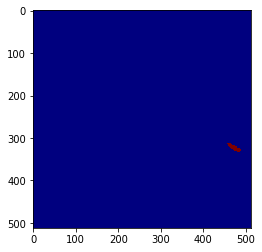

[(0.9215036311619719, 0.6301303917253521)]
IMG53_-575,500_.png
Warning, picture contains sky, passing
IMG540_-750,75_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG541_-775,75_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG542_-800,75_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG543_-825,75_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG544_-850,75_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG545_-875,75_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG546_-900,75_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG547_-925,75_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG548_-950,75_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG549_-975,75_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG54_-600,475_.pn

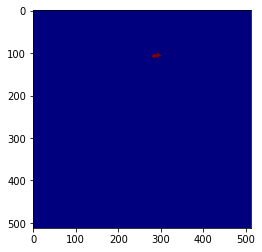

[(0.5643682065217391, 0.20779551630434784)]
IMG593_-725,-100_.png
This image contains 1 animals


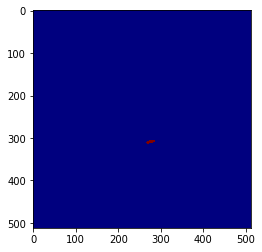

[(0.5380859375, 0.6032492897727273)]
IMG594_-700,-100_.png
This image contains 1 animals


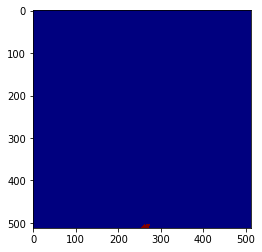

[(0.51788330078125, 0.986846923828125)]
IMG595_-675,-100_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG596_-650,-100_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG597_-625,-100_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG598_-600,-100_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG599_-575,-100_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG59_-725,350_.png
Warning, picture contains sky, passing
IMG5_-100,100_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG600_-550,-100_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG601_-525,-100_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG602_-500,-100_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG603_-475,-100_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG6

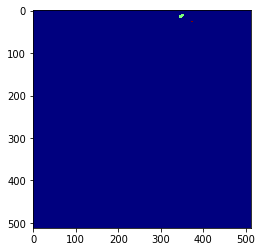

[(0.6915729801829268, 0.032464748475609755), (0.6799710181451613, 0.02624117943548387)]
IMG61_-775,300_.png
Warning, picture contains sky, passing
IMG620_-50,-100_.png
This image contains 4 animals


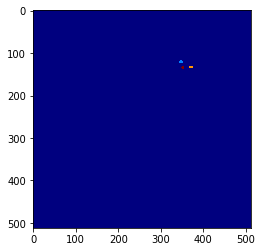

[(0.698066907051282, 0.24994991987179488), (0.6782394935344828, 0.2366985452586207), (0.728515625, 0.237060546875), (0.7236328125, 0.2608309659090909)]
IMG621_-25,-100_.png
This image contains 4 animals


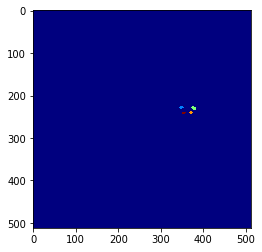

[(0.7073759191176471, 0.45821844362745096), (0.6787860576923077, 0.44583834134615385), (0.7364676339285714, 0.4483119419642857), (0.7231233016304348, 0.46989639945652173)]
IMG622_0,-100_.png
This image contains 4 animals


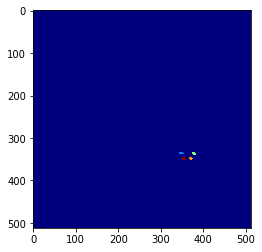

[(0.70703125, 0.6682368259803921), (0.6796875, 0.6552734375), (0.7376663773148148, 0.6578776041666666), (0.72265625, 0.6796875)]
IMG623_25,-100_.png
This image contains 4 animals


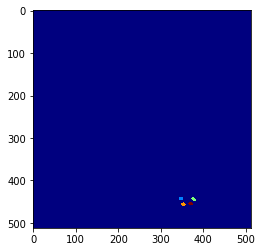

[(0.706177857545045, 0.8771554757882883), (0.6783068426724138, 0.8643925107758621), (0.7364676339285714, 0.8670479910714286), (0.689453125, 0.8904157366071429)]
IMG624_50,-100_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG625_75,-100_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG626_100,-100_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG627_125,-100_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG628_150,-100_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG629_175,-100_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG62_-800,275_.png
Warning, picture contains sky, passing
IMG630_200,-100_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG631_225,-100_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG632_250,-100_.png
This image contains 0 animals
Zero animals in thi

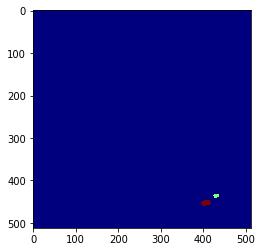

[(0.810929008152174, 0.8709451426630435), (0.8406575520833334, 0.8512369791666666)]
IMG641_325,-25_.png
This image contains 4 animals


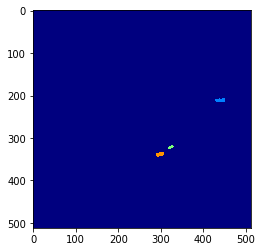

[(0.7095507086431226, 0.5580128949814126), (0.8586115056818182, 0.41273082386363635), (0.6307291666666667, 0.6283854166666667), (0.5823429188829787, 0.660634142287234)]
IMG642_300,0_.png
This image contains 4 animals


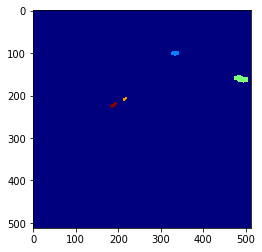

[(0.6882473692602041, 0.32017299107142855), (0.6510225183823529, 0.19743795955882354), (0.954248046875, 0.31484375), (0.4209735576923077, 0.4063251201923077)]
IMG643_275,25_.png
This image contains 4 animals


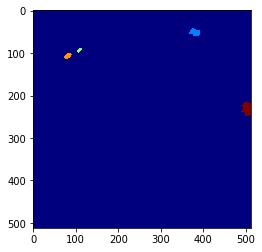

[(0.6274038461538461, 0.2527175834276018), (0.7412380642361112, 0.10283745659722222), (0.2113752693965517, 0.18308863146551724), (0.15879755434782608, 0.21038552989130435)]
IMG644_250,50_.png
This image contains 1 animals


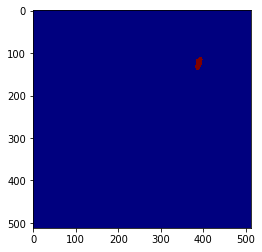

[(0.759521484375, 0.24525282118055555)]
IMG645_225,75_.png
This image contains 1 animals


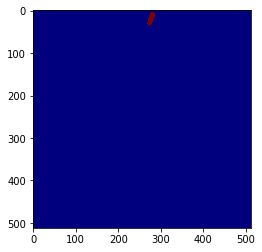

[(0.5395883413461539, 0.04001402243589743)]
IMG646_200,100_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG647_175,100_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG648_150,100_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG649_125,100_.png
This image contains 1 animals


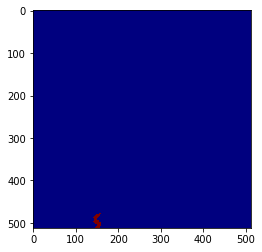

[(0.29419225933908044, 0.962957974137931)]
IMG64_-800,225_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG650_100,100_.png
This image contains 4 animals


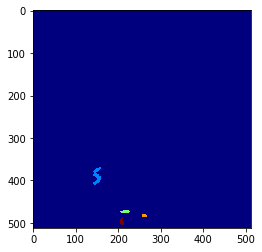

[(0.3698914930555556, 0.8579383680555556), (0.2931640625, 0.7587518601190476), (0.42044132313829785, 0.9232671210106383), (0.5091931573275862, 0.9417093211206896)]
IMG651_75,100_.png
This image contains 15 animals


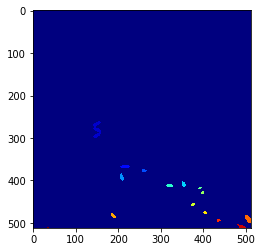

[(0.5717946450541339, 0.7878590981791339), (0.2931421582943925, 0.5476507739485982), (0.4208984375, 0.716796875), (0.5087890625, 0.736328125), (0.40679782774390244, 0.7641720655487805), (0.68994140625, 0.79779052734375), (0.6264229910714286, 0.8039899553571429), (0.7646484375, 0.8154296875), (0.7768811677631579, 0.8365028782894737), (0.7333984375, 0.8918269230769231), (0.789444633152174, 0.9291355298913043), (0.3675537109375, 0.94232177734375), (0.9831000434027778, 0.9563802083333334), (0.8501953125, 0.9640234375), (0.952734375, 0.98798828125)]
IMG652_50,100_.png
This image contains 16 animals


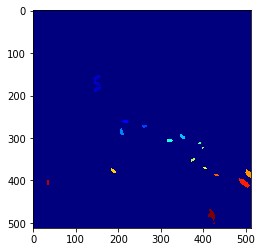

[(0.6086717471358429, 0.6422824391366612), (0.2931786653037383, 0.33536251460280375), (0.421875, 0.510546875), (0.5092954282407407, 0.5309968171296297), (0.4065069901315789, 0.5584395559210527), (0.6849846117424242, 0.5815873579545454), (0.6251220703125, 0.59832763671875), (0.763671875, 0.6100260416666666), (0.7777458639705882, 0.6305721507352942), (0.7338671875, 0.6858203125), (0.78818359375, 0.7234375), (0.3682942708333333, 0.7373697916666667), (0.9837053571428571, 0.7473493303571429), (0.8413298233695652, 0.7563264266304348), (0.9664713541666666, 0.7912791418650794), (0.068359375, 0.7890625)]
IMG653_25,100_.png
This image contains 17 animals


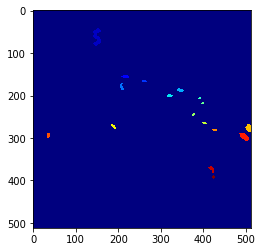

[(0.6008684142561983, 0.42850109762396693), (0.2929875300480769, 0.1228778545673077), (0.4213526526162791, 0.3043468386627907), (0.5092954282407407, 0.32570167824074076), (0.406640625, 0.35048828125), (0.6748589409722222, 0.3672417534722222), (0.6254438920454546, 0.3928444602272727), (0.7635633680555556, 0.4051649305555556), (0.7772216796875, 0.425537109375), (0.7348865327380952, 0.47977120535714285), (0.7870205965909091, 0.517578125), (0.3676600302419355, 0.5319745463709677), (0.9845525568181818, 0.5390329071969697), (0.8325390625, 0.5491796875), (0.06982421875, 0.5741489955357143), (0.9673394097222222, 0.5795975942460317), (0.8199129971590909, 0.7306463068181818)]
IMG654_0,100_.png
This image contains 15 animals


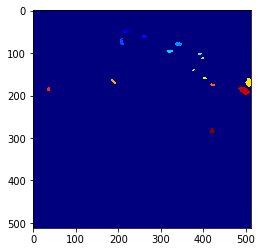

[(0.659294695893595, 0.2705078125), (0.4213324652777778, 0.09819878472222222), (0.5096958705357143, 0.1201171875), (0.4065596417682927, 0.14398342225609756), (0.6658614309210527, 0.15558182565789475), (0.6255030776515151, 0.18764796401515152), (0.7642372532894737, 0.19947574013157895), (0.77734375, 0.2197265625), (0.7353515625, 0.27431640625), (0.7874065896739131, 0.3123726222826087), (0.9840401785714286, 0.3298828125), (0.3682942708333333, 0.32708333333333334), (0.8237485532407407, 0.3419053819444444), (0.0712890625, 0.3612530048076923), (0.96673583984375, 0.368804931640625)]
IMG655_-25,100_.png
This image contains 9 animals


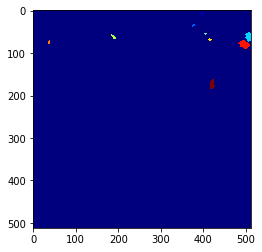

[(0.7570602363074205, 0.16327917954946997), (0.7767578125, 0.014388020833333333), (0.7356305803571429, 0.06849888392857142), (0.9830025337837838, 0.12080342060810811), (0.7891710069444444, 0.10731336805555555), (0.3680943080357143, 0.12130301339285714), (0.81162109375, 0.13447265625), (0.07373046875, 0.14542643229166666), (0.9663158815298507, 0.15745977145522388)]
IMG656_-50,100_.png
This image contains 1 animals


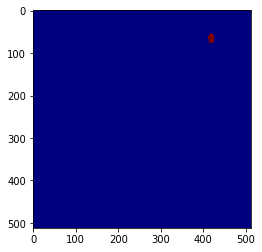

[(0.8165604440789473, 0.12912897478070176)]
IMG657_-75,100_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG658_-100,100_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG659_-125,100_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG65_-800,200_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG660_-150,100_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG661_-175,100_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG662_-200,100_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG663_-225,100_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG664_-250,100_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG665_-275,100_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG666_-300,100_.png
This image contains 0 animals
Zero animals in t

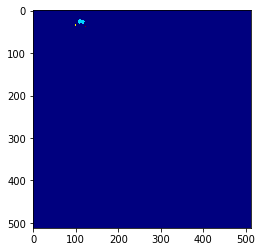

[(0.21911821209016394, 0.05864177766393443), (0.22025057164634146, 0.051995998475609755), (0.1953125, 0.068359375)]
IMG676_-50,350_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG677_-25,375_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG678_0,400_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG679_25,425_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG67_-800,150_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG680_50,450_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG681_75,475_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG682_100,500_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG683_125,525_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG684_150,550_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG685_17

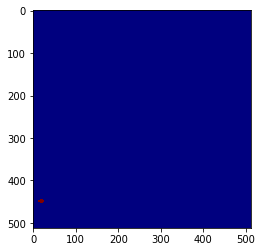

[(0.03602430555555555, 0.8766818576388888)]
IMG72_-800,25_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG730_650,-125_.png
This image contains 1 animals


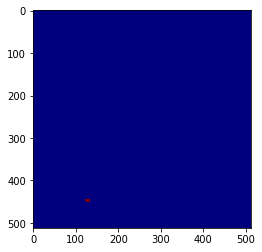

[(0.2490234375, 0.87200927734375)]
IMG731_650,-150_.png
This image contains 1 animals


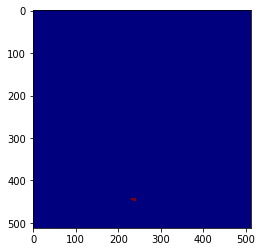

[(0.46144261853448276, 0.8677599676724138)]
IMG732_650,-175_.png
This image contains 1 animals


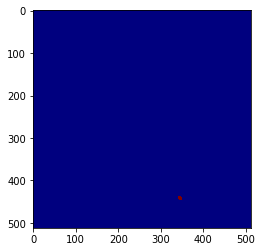

[(0.6734302662037037, 0.8625217013888888)]
IMG733_650,-200_.png
This image contains 1 animals


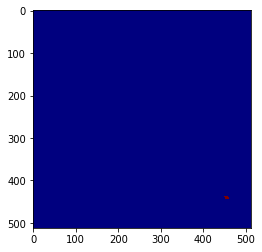

[(0.8862136314655172, 0.8575902478448276)]
IMG734_650,-225_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG735_650,-250_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG736_650,-275_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG737_650,-300_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG738_650,-325_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG739_650,-350_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG73_-800,0_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG740_650,-375_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG741_650,-400_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG742_650,-425_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG743_650,-450_.png
This image contains 0 animals
Zero animals in thi

This image contains 0 animals
Zero animals in this picture, passing
IMG819_1100,-350_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG81_-800,-200_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG820_1100,-325_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG821_1100,-300_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG822_1100,-275_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG823_1100,-250_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG824_1100,-225_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG825_1100,-200_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG826_1100,-175_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG827_1100,-150_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG828_1100,-125_.png
This image 

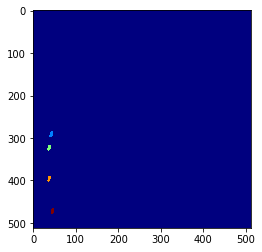

[(0.08018663194444445, 0.7264539930555556), (0.08241595643939394, 0.5697502367424242), (0.07456341911764706, 0.6291360294117647), (0.07366943359375, 0.7716064453125)]
IMG840_1100,175_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG841_1100,200_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG842_1100,225_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG843_1100,250_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG844_1100,275_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG845_1100,300_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG846_1100,325_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG847_1100,350_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG848_1100,375_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG849_1100,400_.png
This image 

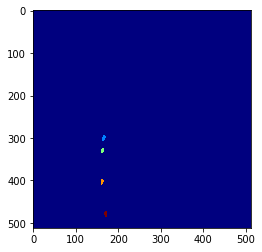

[(0.3226159947519084, 0.7384527075381679), (0.3245442708333333, 0.5853752367424242), (0.3174419981060606, 0.6439689867424242), (0.31568170362903225, 0.7858177923387096)]
IMG850_1100,425_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG851_1100,450_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG852_1100,475_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG853_1100,500_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG854_1100,525_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG855_1100,550_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG856_1100,575_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG857_1100,600_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG858_1100,625_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG859_1100,650_.png
This ima

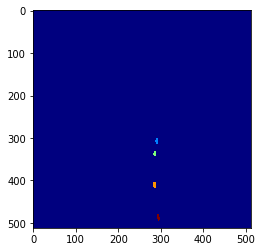

[(0.5647683932086615, 0.7611727977362205), (0.56689453125, 0.6005859375), (0.5587332589285714, 0.6571568080357143), (0.5569871471774194, 0.8013167842741935)]
IMG860_1100,675_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG861_1100,700_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG862_1100,725_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG863_1100,750_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG864_1075,725_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG865_1050,700_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG866_1025,675_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG867_1000,650_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG868_975,625_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG869_950,600_.png
This image contains 0 

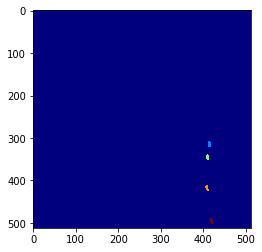

[(0.8061079545454546, 0.7698567708333334), (0.8082090435606061, 0.6137843276515151), (0.80035400390625, 0.6739501953125), (0.7983842329545454, 0.8160215435606061)]
IMG870_925,575_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG871_900,550_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG872_875,525_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG873_850,500_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG874_825,475_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG875_800,450_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG876_775,425_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG877_750,400_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG878_725,375_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG879_700,350_.png
This image contains 0 an

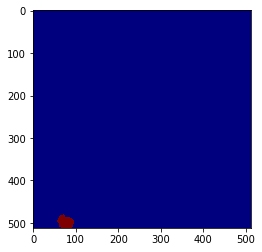

[(0.14687965029761904, 0.9636462983630952)]
IMG906_25,300_.png
This image contains 2 animals


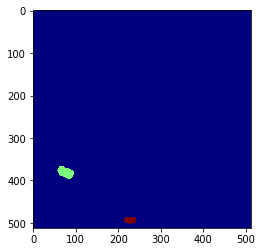

[(0.27455274593195267, 0.8369140625), (0.14850797358247422, 0.7437681217783505)]
IMG907_0,300_.png
This image contains 2 animals


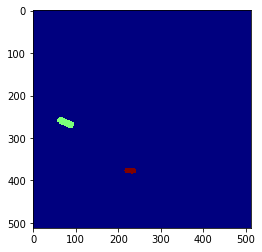

[(0.2760032511645963, 0.6098541828416149), (0.14937160326086957, 0.5148182744565217)]
IMG908_-25,300_.png
This image contains 2 animals


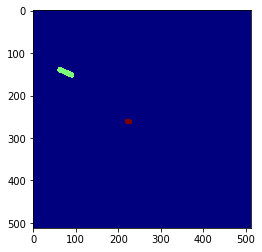

[(0.2479444383741259, 0.3625095607517482), (0.14937250664893617, 0.28563414228723405)]
IMG909_-50,300_.png
This image contains 2 animals


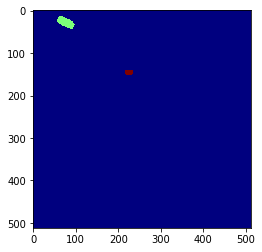

[(0.24842447916666666, 0.13428385416666666), (0.14972971906565657, 0.05688723169191919)]
IMG90_-800,-425_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG910_-75,300_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG911_-100,300_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG912_-125,300_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG913_-150,300_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG914_-175,300_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG915_-200,300_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG916_-225,300_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG917_-250,300_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG918_-275,300_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG919_-300,300_.png
T

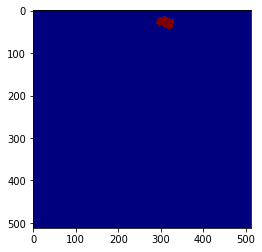

[(0.6072560436320755, 0.05586674528301887)]
IMG992_-25,250_.png
This image contains 2 animals


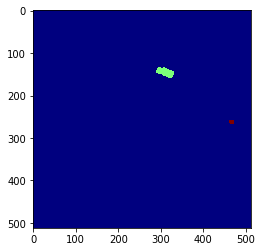

[(0.6911908318014706, 0.3482450597426471), (0.6062460140306123, 0.2846580038265306)]
IMG993_0,250_.png
This image contains 2 animals


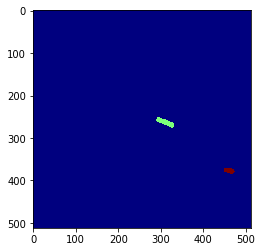

[(0.722792227056962, 0.6024401700949367), (0.6059930098684211, 0.5138260690789473)]
IMG994_25,250_.png
This image contains 2 animals


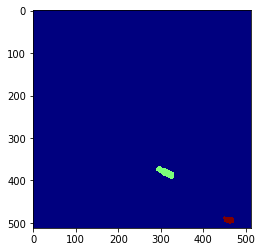

[(0.7274350499260355, 0.834128836908284), (0.6075895675505051, 0.7438742897727273)]
IMG995_50,250_.png
This image contains 1 animals


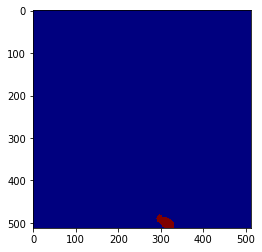

[(0.6029861634036144, 0.964820218373494)]
IMG996_75,250_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG997_100,250_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG998_125,250_.png
This image contains 1 animals


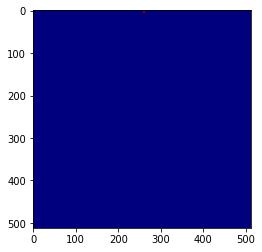

[(0.5087890625, 0.007238051470588236)]
IMG999_150,250_.png
This image contains 2 animals


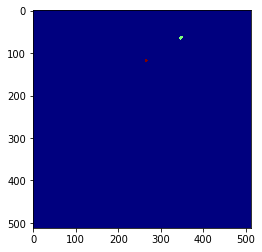

[(0.6133277529761905, 0.16861979166666666), (0.6780078125, 0.1262890625)]
IMG99_-800,-650_.png
This image contains 0 animals
Zero animals in this picture, passing
IMG9_-175,200_.png
This image contains 0 animals
Zero animals in this picture, passing


<Figure size 432x288 with 0 Axes>

In [8]:
with open("../Data/labels/00_SPLIT.txt","w") as file: 
    print(os.listdir("../Data/semantic/2019-10/"))
    print(len(os.listdir("../Data/semantic/2019-10/")))
    for image_name in os.listdir("../Data/semantic/2019-10/"):

        # Input image from directory
        print(image_name)
        input_location_s = "../Data/semantic/2019-10/"
        input_image_s = input_location_s + image_name

        # Write file name to 00_SPLIT.txt file
        file.write("2019-10/" + image_name + ' ' + "1")
        file.write("\n")
        
        # If image contains sky, i.e. it's under the ground level, continue
        sky_check = check_sky(input_image_s)
        if sky_check == True:
            bad_image_list1.append(image_name)
            continue
                    
        # Mask everything but animals in image
        animals, mask = mask_seg(input_image_s)

        # Smooth animals with gaussian and remove tiny animals less than set size
        animals_smooth, T = smooth_animals(animals, sigma = sigma,size = minimum_animal_size)

        # Count animals, if no animals are present, skip image
        labeled_animals, nr_objects = count_animals(animals_smooth, T)
        if nr_objects == 0:
            print("Zero animals in this picture, passing")
            continue
        
        # Get centers of animals using boundaries
        centers_list = get_centers_through_borders(labeled_animals, nr_objects)
        
        # Get bboxes of animals in image
        #centers_list = get_centers(animals_smooth,clean_distance = clean_distance) # old
        bbox_list = get_bboxes(labeled_animals)

        # Output centers and bboxes
        bad_image_list2 = write_file(output_location,image_name,centers_list,bbox_list)


In [ ]:

# Turn on to delete images that have innapropriate compositions in them
print(bad_image_list1)
print(bad_image_list2)
bad_image_list = band_image_list1 + band_image_list2

"""
for image in bad_image_list:
    os.remove("../Data/images/2019-10/" + image)
    os.remove("../Data/semantic/2019-10/" + image)
"""